In [2]:
from nmon import *


 /Users/nikolaygusarov/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py: 34

nmon [-45.84581527+0.j -38.75825281+0.j -30.16549579+0.j -21.43664505+0.j
 -20.92495007+0.j -20.78572979+0.j]


 /Users/nikolaygusarov/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py: 1345

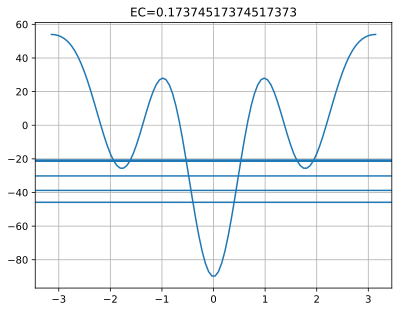

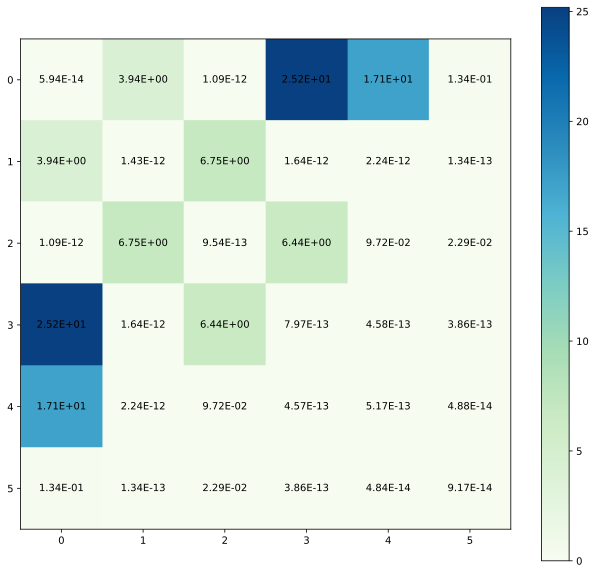

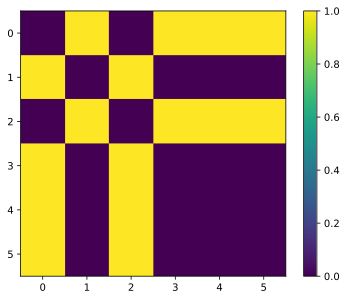

In [4]:
N = 1
M = 4
EC_shunt = 0.18

nmon = Nmon(N=N, M=M, EJN=100*EC_shunt, EJM=100*EC_shunt, EC_shunt=EC_shunt)

nmon.hamiltonian_calc(flux=0.0, ng=[0.0, 0.0, 0.0, 0.0, 0.0], num_levels=6, make_plot=True, cutoff=3)

# nmon.H = nmon.nmon_circ.hamiltonian()#.toarray() # sparse array
# nmon.evals, nmon.evecs = spla.eigsh(nmon.H, k=6, which='SA')
# nmon.H.shape


In [3]:
print("EC", nmon.EC_total)
print("EC shunt", nmon.EC_shunt)
print("total C", nmon.C_total)

print('total L', nmon.L_total)
print('Expected freq', 1/ np.sqrt(nmon.L_total*nmon.C_total)/1e9)

print("EJM", nmon.EJM)
print("EJN", nmon.EJN)
print("ECJM", nmon.ECJM)
print("ECJN", nmon.ECJN)

print(nmon.bound_state_energies[1] - nmon.bound_state_energies[0])
print(nmon.bound_state_energies[2] - nmon.bound_state_energies[1])

# print(nmon.bound_state_energies[2] - nmon.bound_state_energies[0])
# print(nmon.bound_state_energies[4] - nmon.bound_state_energies[2])
# print(nmon.bound_state_energies[4] - nmon.bound_state_energies[2])
print(nmon.ready_dominating_transitions)
print(nmon.transition_freqs)
print(nmon.relative_anharm)

EC 0.1793543244320446
EC shunt 0.18
total C 1.0770768353623773e-13
total L 7.259175010545461e-08
Expected freq 11.309229665951879
EJM 1.7999999999999998
EJN 1.7999999999999998
ECJM 62.50000000000001
ECJN 62.50000000000001
(1.434430887708762+0j)
(0.9751136078014395+0j)
[(0, 1, 1.7275964781976632), (1, 2, 2.2691499929744365), (2, 3, 1.3195207070622843), (3, 4, 4.627975573070257)]
[(1.434430887708762+0j), (0.9751136078014395+0j), (1.837209748759877+0j), (0.06763376751821948+0j)]
(-0.32020872099386877+0j)


In [4]:
from nmon import *

EC_shunt = 0.18

N = 1
M = 4

N_EJN = 10
N_EJM = 10
N_flux = 5

flux_list = np.linspace(0, 0.5, N_flux)
EJM_list = np.linspace(1 * EC_shunt, 100 * EC_shunt, N_EJN)
EJN_list = np.linspace(1 * EC_shunt, 100 * EC_shunt, N_EJM)

# Generate all combinations of ng values
ng_probes = [0, 0.25, 0.5, 0.75]
ng_combinations = np.array(list(combinations_with_replacement(ng_probes, N + M - 1)))

relative_anharm_list = np.zeros((N_EJM, N_EJN, N_flux))
w01_list = np.zeros((N_EJM, N_EJN, N_flux))
w12_list = np.zeros((N_EJM, N_EJN, N_flux))
w01_variation_list = np.zeros_like(w01_list)

# To store the ng values corresponding to min and max w01
w01_ng_min = np.empty((N_EJM, N_EJN, N_flux), dtype=object)
w01_ng_max = np.empty((N_EJM, N_EJN, N_flux), dtype=object)

for i in range(N_EJM):
    for j in tqdm(range(N_EJN)):
        nmon = Nmon(N=N, M=M, EJM=EJM_list[i], EJN=EJN_list[j], EC_shunt=EC_shunt)
        for k, flux in enumerate(flux_list):

            w01_local = []
            local_ng_values = []

            # Iterate over all ng combinations
            for ng in ng_combinations:
                try:
                    nmon.hamiltonian_calc(flux=flux, ng=ng, num_levels=6, make_plot=False, just_H=False,
                                        cutoff=compute_cutoff(nmon.EJN, nmon.EJM, nmon.EC_total, cutoff_space=[2, 3]))
                except Exception:
                    continue

                # Store w01 for the current ng
                w01_local.append(nmon.transition_freqs[0])
                local_ng_values.append(tuple(ng))

                if len(nmon.transition_freqs) > 1:
                    w12_list[i, j, k] = nmon.transition_freqs[1]

            # Compute relative anharmonicity
            relative_anharm_list[i, j, k] = nmon.relative_anharm
            w01_list[i, j, k] = np.min(w01_local)  # Store the minimal w01 for any ng configuration

            # Calculate w01 variation and store ng values for min and max w01
            max_idx = np.argmax(w01_local)
            min_idx = np.argmin(w01_local)

            w01_variation_list[i, j, k] = (w01_local[max_idx] - w01_local[min_idx]) / w01_local[min_idx]
            w01_ng_min[i, j, k] = local_ng_values[min_idx]
            w01_ng_max[i, j, k] = local_ng_values[max_idx]

# At the end, w01_ng_min and w01_ng_max store the ng values for which w01 is minimal or maximal.
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), flux_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_max.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_max)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_ng_min.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_ng_min)



  0%|          | 0/20 [00:00<?, ?it/s]ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/54/_13g4g016975q4kygn1_b9jw0000gn/T/ipykernel_49070/304528334.py: 33ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/54/_13g4g016975q4kygn1_b9jw0000gn/T/ipykernel_49070/304528334.py: 34ComplexWarning: Casting complex values to real discards the imaginary part
 /var/folders/54/_13g4g016975q4kygn1_b9jw0000gn/T/ipykernel_49070/304528334.py: 36ComplexWarning: Casting complex values to real discards the imaginary part
100%|██████████| 20/20 [13:09<00:00, 39.50s/it]


In [5]:
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJM_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), EJN_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), flux_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), relative_anharm_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_list)
np.save("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(nmon.N, nmon.M, round(nmon.EC_shunt,2 )), w01_variation_list)


In [6]:

EJM_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJM_list.npy".format(N, M, round(EC_shunt, 2)))
EJN_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_EJN_list.npy".format(N, M, round(EC_shunt, 2)))
flux_list = np.load("./data_arrays/N={}_M={}_EC_shunt={}_flux_list.npy".format(N, M, round(EC_shunt, 2)))
relative_anharm_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_rel_anharm_list.npy".format(N, M, round(EC_shunt, 2)))
w01_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_list.npy".format(N, M, round(EC_shunt, 2)))
w01_variation_list_flux = np.load("./data_arrays/N={}_M={}_EC_shunt={}_w01_variation_list.npy".format(N, M, round(EC_shunt, 2)))

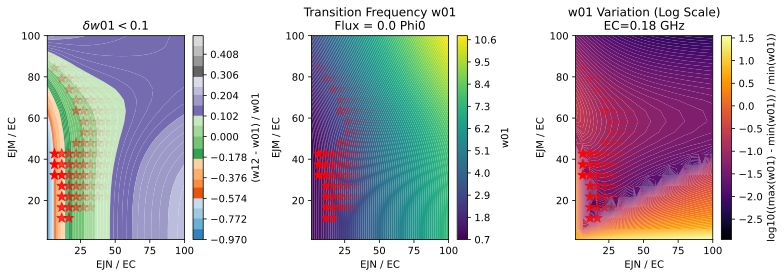

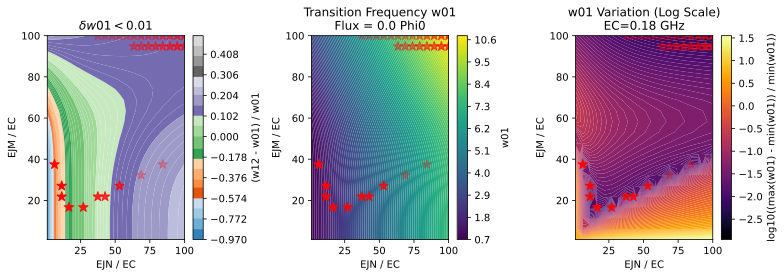

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

w01_variation_levels = [1e-1, 10**(-2), 10**(-3)]

for w01_variation_lev in w01_variation_levels:

    for k, flux_value in enumerate(flux_list):

        EJN_grid, EJM_grid = np.meshgrid(EJN_list, EJM_list)

        # Extract arrays for the current flux value
        relative_anharm_list = relative_anharm_list_flux[:, :, k]
        w01_list = w01_list_flux[:, :, k]
        w01_variation_list = w01_variation_list_flux[:, :, k]

        # Replace NaN values in relative_anharm_list
        relative_anharm_list[np.isnan(relative_anharm_list)] = 1

        # Create DataFrame for all data points
        data = {
            'EJN': EJN_grid.flatten(),
            'EJM': EJM_grid.flatten(),
            'RelativeAnharmonicity': relative_anharm_list.flatten(),
            'w01': w01_list.flatten(),
            'w01Variation': w01_variation_list.flatten()
        }
        df = pd.DataFrame(data)

        # Filter rows where w01Variation < 10^(-1)
        filtered_df = df[df['w01Variation'] < w01_variation_lev]

        # Identify the top N_anharm points (lowest anharmonicity values)
        N_anharm = 100
        best_points = filtered_df.nsmallest(N_anharm, 'RelativeAnharmonicity')
    
        # Adjust alpha values for star-points
        best_anharm_values = best_points['RelativeAnharmonicity'].values

        if len(best_anharm_values) < 2:
            break

        alphas = np.ones(N_anharm)
        for i in range(1, N_anharm):
            if abs(best_anharm_values[i] - best_anharm_values[i - 1]) > 1e-3:
                alphas[i:] = np.logspace(0, -2, N_anharm - i)
                break

        # Plot with contourf and overlay star-points
        fig, axes = plt.subplots(1, 3, figsize=(11, 4))

        # First subplot: Relative Anharmonicity
        norm = colors.TwoSlopeNorm(vmin=df['RelativeAnharmonicity'].min(), vcenter=0, vmax=0.5)
        levels = np.concatenate((np.linspace(df['RelativeAnharmonicity'].min(), -1e-5, 50), 
                                np.linspace(0, 0.5, 50)))
        im1 = axes[0].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            relative_anharm_list, levels=levels, cmap='tab20c', norm=norm)
        fig.colorbar(im1, ax=axes[0], label='(w12 - w01) / w01')
        axes[0].set_title(r"$\delta w01 < {}$".format(round(w01_variation_lev, 3)))
        axes[0].set_xlabel('EJN / EC')
        axes[0].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[0].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Second subplot: w01
        im2 = axes[1].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            w01_list, levels=100, cmap='viridis')
        fig.colorbar(im2, ax=axes[1], label='w01')
        axes[1].set_title(f"Transition Frequency w01\nFlux = {flux_value} Phi0")
        axes[1].set_xlabel('EJN / EC')
        axes[1].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[1].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Third subplot: Log10 of w01 Variation
        im3 = axes[2].contourf(EJN_grid / EC_shunt, EJM_grid / EC_shunt, 
                            np.log10(w01_variation_list), levels=100, cmap='inferno')
        fig.colorbar(im3, ax=axes[2], label='log10((max(w01) - min(w01)) / min(w01))')
        axes[2].set_title(f"w01 Variation (Log Scale)\nEC={round(EC_shunt, 2)} GHz")
        axes[2].set_xlabel('EJN / EC')
        axes[2].set_ylabel('EJM / EC')

        # Overlay star-points
        axes[2].scatter(best_points['EJN'] / EC_shunt, best_points['EJM'] / EC_shunt, 
                        s=100, c='red', marker='*', alpha=alphas)

        # Adjust layout and save the figure
        plt.tight_layout()
        plt.savefig(f"./data_figures/N={N}_M={M}_EC={round(EC_shunt, 2)}_flux_{k}_combined_plots.pdf")
        plt.show()
